(832, 1100, 3)


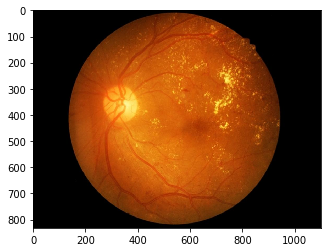

In [274]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import cluster
import seaborn as sns

img = cv2.imread('./diabetic-retinopathy-header.jpg')
# img = cv2.imread('./vehicle_palette.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
print(img.shape)

In [255]:
def info_image(im):
    # Compute the center (cx, cy) and radius of the eye
    cy = im.shape[0]//2
    midline = im[cy,:]
    midline = np.where(midline>midline.mean()/3)[0]

    if len(midline)>im.shape[1]//2:
        x_start, x_end = np.min(midline), np.max(midline)
    else: # This actually rarely happens p~1/10000
        x_start, x_end = im.shape[1]//10, 9*im.shape[1]//10
    cx = (x_start + x_end)/2
    r = (x_end - x_start)/2
    return cx, cy, r

In [235]:
def resize_image(im, augmentation=True):
    # Crops, resizes and potentially augments the image to IMAGE_SIZE
    cx, cy, r = info_image(im)
    scaling = IMAGE_SIZE/(2*r)
    rotation = 0
    if augmentation:
        scaling *= 1 + 0.3 * (np.random.rand()-0.5)
        rotation = 360 * np.random.rand()
    M = cv2.getRotationMatrix2D((cx,cy), rotation, scaling)
    M[0,2] -= cx - IMAGE_SIZE/2
    M[1,2] -= cy - IMAGE_SIZE/2
    return cv2.warpAffine(im,M,(IMAGE_SIZE,IMAGE_SIZE)) # This is the most important line

In [269]:
def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

In [280]:
def radius_reduction(img, PARAM):
    h, w, c=img.shape
    frame0 = np.zeros((h, w, c), dtype = np.uint8)
    
    cv2.circle(frame0, (int(np.floor(w / 2)), int(np.floor(h / 2))),
                       int(np.floor((h * PARAM) / float(2 * 100))), (255, 255, 255), -1)
    
    frame1 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
    res = cv2.bitwise_and(img, img, mask=frame1)
    return res

In [282]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

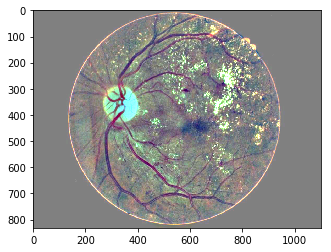

In [284]:
IMAGE_SIZE = 330
PARAM = 96

plt.imshow(subtract_median_bg_image(img))

### Image Gradients

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


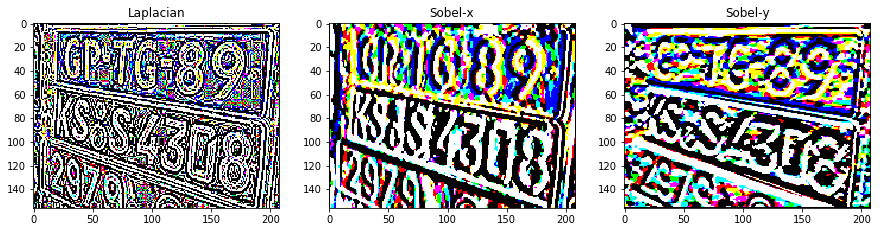

In [212]:
laplacian = cv2.Laplacian(img, cv2.CV_64F)

sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)

sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 3, 1)
plt.title('Laplacian')
plt.imshow(laplacian)

fig.add_subplot(1, 3, 2)
plt.title('Sobel-x')
plt.imshow(sobel_x)

fig.add_subplot(1, 3, 3)
plt.title('Sobel-y')
plt.imshow(sobel_y)

In [156]:
def resize_img_adaptively(img_gr, img_cnt, dim, interpolation):
    """
    img_gr - original image in grayscale
    img_cnt - max image contour
    """
    (x,y), radius = cv2.minEnclosingCircle(cnt)
            
    x = int(x); y = int(y); radius = int(radius)
    
    if x < radius:
        radius = x
    if y < radius:
        radius = y
    
    crop_img = img_gr[y - radius:y + radius, x - radius:x + radius]
    
    resized = cv2.resize(crop_img, dim, interpolation=interpolation)
    
    return resized

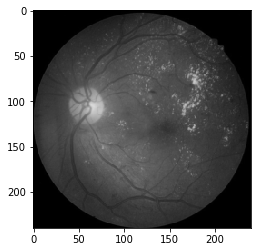

In [157]:
ret, thresh = cv2.threshold(img_grayscale, 0, 255, cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh, 1, 2)
cnt = max(contours, key = cv2.contourArea)

img = resize_img_adaptively(img_grayscale, cnt, (240, 240), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
plt.imshow(img)

In [158]:
dim = img.shape
img_matrix = np.reshape(img, (dim[0] * dim[1], dim[2]))

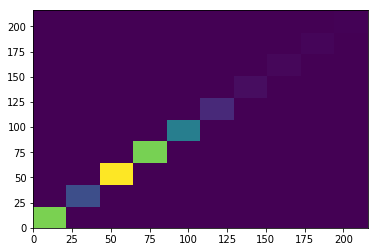

In [159]:
_ = plt.hist2d(img_matrix[:,1], img_matrix[:,2], bins=(10,10))

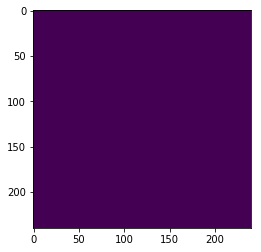

In [160]:
plt.imshow(img[:,:,0] - img[:,:,1])

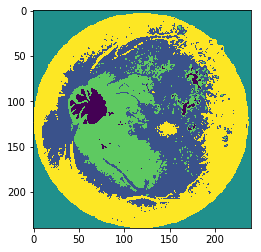

In [161]:
kmeans = cluster.KMeans(5)
clustered = kmeans.fit_predict(img_matrix)

clustered_img = np.reshape(clustered, (dim[0], dim[1]))
plt.imshow(clustered_img)

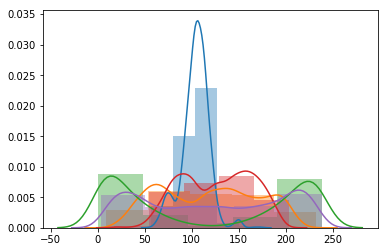

In [162]:
ind0, ind1, ind2, ind3, ind4 = [np.where(clustered_img == x)[0] for x in [0, 1, 2, 3, 4]]

sns.distplot(ind0, bins=5)
sns.distplot(ind1, bins=5)
sns.distplot(ind2, bins=5)
sns.distplot(ind3, bins=5)
sns.distplot(ind4, bins=5)

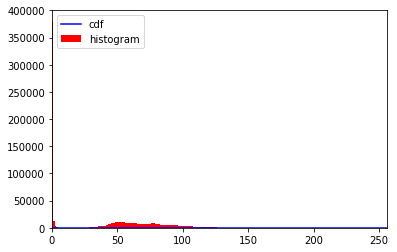

In [163]:
hist, bins = np.histogram(img_grayscale.flatten(),256,[0,256])

cdf = np.cumsum(img_grayscale.flatten())

cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img_grayscale.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

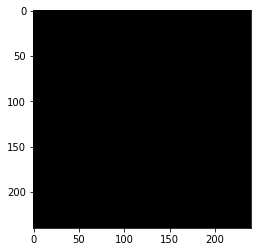

In [164]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

img2 = cdf[img]

plt.imshow(img2)

In [138]:
def bnormalize(mat):
    print(mat.shape)
    """much faster brightness normalization, since it's all vectorized"""
    bnorm = np.zeros_like(mat, dtype=np.float32)
    maxes = np.max(mat, axis=1)
    print(maxes.shape)
    bnorm = mat / maxes
    return bnorm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
(240, 3)


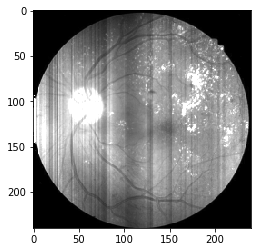

In [139]:
plt.imshow(bnormalize(img))

In [189]:
import numpy as np
import cv2

class ImgStore():
    """Lightweight wrapper for handling image to different transforms."""

    def __init__(self, img):
        self.img = img
        self.dims = img.shape

        if len(self.dims) == 3:
            self.mat = np.reshape(img, (self.dims[0] * self.dims[1], self.dims[2]))
        else:
            self.mat = np.reshape(img, (self.dims[0] * self.dims[1]))

    def foo(self):
        print('bar')
            
    def resize_img_aspect(self, times, interpolation):
        """
        image - original image
        times - int, image resize ratio
        """

        rows0 = self.img.shape[0]
        cols0 = self.img.shape[1]

        rows_n = int(np.floor(rows0 * times))
        cols_n = int(np.floor(cols0 * times))

        resized = cv2.resize(self.img, (cols_n, rows_n), interpolation=interpolation)

        return resized

    def resize_img_circle(self, image_cnt, dim, interpolation):
        """
        image - original image
        image_cnt - array-like, given image contour
        dim - int, image size by length of the on of the image edges
        """
        (x, y), radius = cv2.minEnclosingCircle(image_cnt)

        x = int(x);
        y = int(y);
        radius = int(radius)

        if x < radius:
            radius = x
        if y < radius:
            radius = y

        crop_img = self.img[y - radius:y + radius, x - radius:x + radius]

        resized = cv2.resize(crop_img, (dim, dim), interpolation=interpolation)

        return resized

    def matrix(self):
        return self.mat

    def image(self):
        return self.img

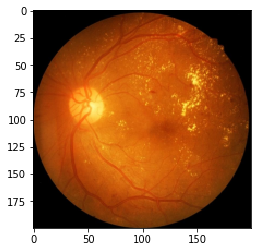

In [194]:
# from classes.ImgStore import ImgStore

i = ImgStore(img)

ret, thresh = cv2.threshold(img_grayscale, 0, 255, cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh, 1, 2)
cnt = max(contours, key = cv2.contourArea)

resized = i.resize_img_circle(cnt, 200, interpolation=cv2.INTER_AREA)

# resized.shape
plt.imshow(resized)

In [ ]:
dst = cv.Laplacian(src_gray, ddepth, ksize=kernel_size)